In [139]:
#PREP - intakes SAR predictions from Earth Engine and creates csv of coordinates of 
#1 sq km areas to request from bing maps.

import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin

import shapely
from shapely.geometry import mapping

from coord import coord
from explode import explode
import matplotlib.pyplot as plt

In [140]:
#SET COUNTRY/CRS <-------------------------------------------------------------------------------CHANGE
#n = ['TUR', 'EPSG:5637'] #turkey
#n = ['GRC', 'EPSG:2100'] #greece
# n = ['ESP', 'EPSG:2062'] #spain
# n = ['HRV', 'EPSG:3765'] #croatia
# n = ['ITA', 'EPSG:7794'] #italy
# n = ['CYP', 'EPSG:6312'] #cyprus
# n = ['MLT', 'EPSG:3034'] #malta
# n = ['FRA', 'EPSG:2154'] #france
n = ['ALB', 'EPSG:6962'] #albania
wgs84= {'init' :'EPSG:4326'}

#open file
f = '../targets_0_sar/'
pts = gpd.read_file(f + 'sar_' + n[0] + '.geojson')

In [141]:
#load search area and exclusion zones
f2 = '/Users/Zack/0_seawarden/'
search_area = gpd.read_file(f2 + '0_search_areas/4_search_area/search_area_100m_' + n[0] + '.shp')
exclusion_zones = gpd.read_file(f2 + '0_search_areas/7_exclusions/' + n[0] + '_exclusions.geojson')

#re-project layers
pts = pts.to_crs({'init': n[1]})
search_area = search_area.to_crs({'init': n[1]})
exclusion_zones = exclusion_zones.to_crs({'init': n[1]})

print('detections', len(pts), pts.crs)
print('search area', len(search_area), search_area.crs)
print('exclusion zones', len(exclusion_zones), exclusion_zones.crs)

detections 2303 {'init': 'EPSG:6962'}
search area 1 {'init': 'EPSG:6962'}
exclusion zones 4 {'init': 'EPSG:6962'}


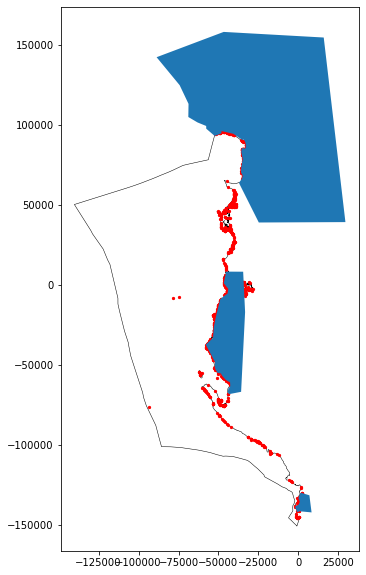

In [142]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
pts.plot(markersize=5, facecolor='red', ax=ax)
exclusion_zones.plot(ax=ax)

In [143]:
%%time 
#clip points to search area
clip = sjoin(pts, search_area, how='inner', op='within')
print('detections within search area:', len(clip))

detections within search area: 2257
Wall time: 290 ms


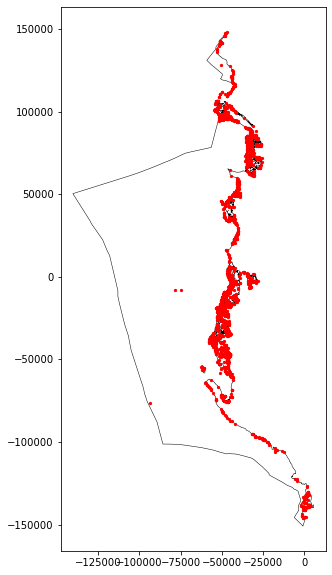

In [144]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
clip.plot(markersize=5, facecolor = 'red', ax=ax)

In [145]:
%%time 
#combine all exclusion zones
exclusion_zones['Dissolve'] = 0
exclusion_zones_dis = exclusion_zones.dissolve(by='Dissolve')

Wall time: 15.1 ms


In [146]:
%%time 
#exclude points in exclusion areas
mask = ~clip.within(exclusion_zones_dis.loc[0, 'geometry'])
clip2 = clip.loc[mask]
print('detections outside of exclusion zones:', len(clip2))

detections outside of exclusion zones: 662
Wall time: 174 ms


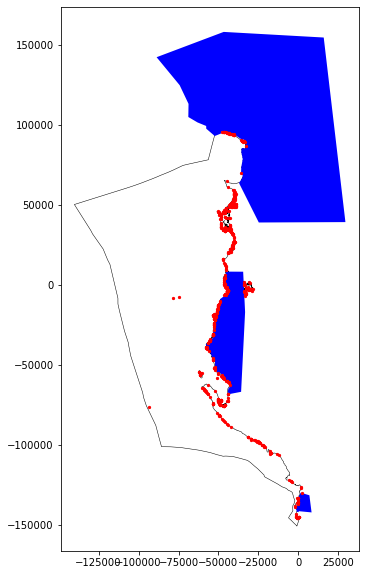

In [147]:
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
exclusion_zones_dis.plot(facecolor = 'blue', ax=ax)
clip2.plot(markersize=5, facecolor = 'red', ax=ax)

In [148]:
%%time 
#buffer points, dissolve buffers to aggregate points near each other
buffer = gpd.GeoDataFrame(geometry = clip2.buffer(10))
buffer['Dissolve'] = 0
buffer_dis = buffer.dissolve(by='Dissolve')

Wall time: 43.4 ms


In [149]:
%%time 
#explode polygon and generate centroids
buffer_exploded = explode(buffer_dis)      
centroids = gpd.GeoDataFrame(geometry = buffer_exploded.centroid)
#centroids = gpd.GeoDataFrame(geometry = pts.centroid)
print('detections after aggregation:', len(centroids))
centroids.crs = {'init' : crs}

detections after aggregation: 656
Wall time: 204 ms


In [150]:
%%time 
#buffer centroids and make square polygons
centroid_buffer = gpd.GeoDataFrame(geometry = centroids.buffer(500))
envelope = gpd.GeoDataFrame(geometry = centroid_buffer.envelope)
print(len(envelope))

656
Wall time: 47 ms


In [151]:
%%time 
# #aggregate overlapping envelopes - new method to create less overlapping requests
# envelope['Dissolve'] = 0
# envelope_dis = envelope.dissolve(by='Dissolve')
# envelope_explode = explode(envelope_dis)   

# #simplify aggregations to envelope
# envelope_envelope = gpd.GeoDataFrame(geometry = envelope_explode.envelope)
# envelope_envelope.shape

#aggreation bypass
envelope_envelope =envelope
envelope.shape

Wall time: 0 ns


(656, 1)

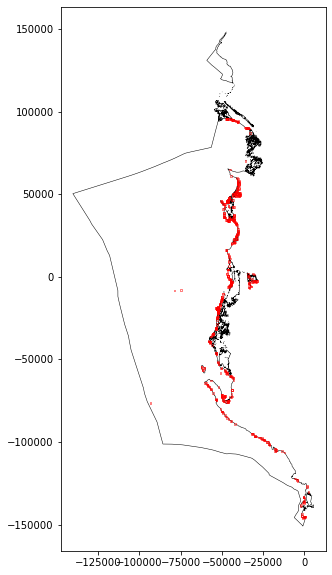

In [152]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
envelope_envelope.plot(linewidth=.5, edgecolor = 'red', facecolor = 'none', ax=ax)

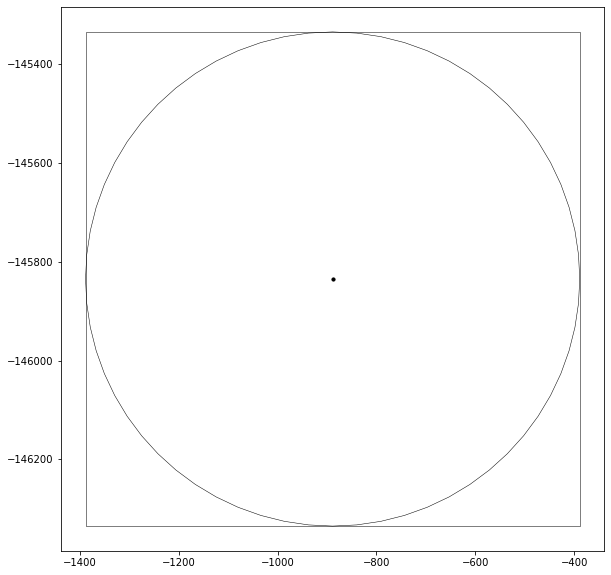

In [153]:
plt.rcParams['figure.figsize'] = (20, 10)
ax = centroids.loc[[0], 'geometry'].plot(markersize=10, facecolor = 'black')
centroid_buffer.loc[[0], 'geometry'].plot(linewidth=.5, edgecolor = 'black', facecolor = 'none', ax=ax)
envelope.loc[[0], 'geometry'].plot(linewidth=.5, edgecolor = 'black', facecolor = 'none', ax=ax)

In [154]:
env = envelope_envelope.copy()
envelope_pts =  gpd.GeoDataFrame(geometry = env.centroid)
envelope_pts.crs = {'init' : crs}

#set crs
env.crs = {'init' : crs}
env['geometry'] = env['geometry'].to_crs(epsg=4326)
print(env.crs)
env.head()

{'init': 'epsg:2062'}


,geometry
0,POLYGON ((-10.09725570197228 33.08749811953244...
1,POLYGON ((-10.09645281166557 33.08810248421083...
2,POLYGON ((-10.08972961437201 33.09074975062072...
3,POLYGON ((-10.09003828204737 33.09190793453819...
4,POLYGON ((-10.08299521669505 33.09244040611637...


In [155]:
#extract lat/long for each square polygon (envelope)
coord_list = []
for i in range(len(env)):
    coords = mapping(env.geometry[i])['coordinates']
    coord_list.append(coords)

In [156]:
#combine x/y point groups
coord_all = []
for i in range(len(coord_list)):
    coord_group = coord(coord_list[i]) #function to extract and format x/y points
    coord_group['id'] = i
    coord_all.append(coord_group) 
targets = pd.concat(coord_all)
print('total coordinates (5 per detection):', len(targets))
targets.head()

total coordinates (5 per detection): 3280


,x,y,id
0,-10.097255701972278,33.08749811953244,0
1,-10.086634781013041,33.08814160638638,0
2,-10.087398618342137,33.09708290279269,0
3,-10.098020798415646,33.096439328642866,0
4,-10.097255701972278,33.08749811953244,0


In [157]:
envelope = envelope_envelope
envelope.crs = {'init' : crs}
envelope.head()

,geometry
0,POLYGON ((-1388.761609621165 -146334.878602220...
1,POLYGON ((-1308.712992248099 -146273.050394852...
2,POLYGON ((-657.7721799992478 -146023.831220714...
3,POLYGON ((-677.4120408076791 -145892.885622127...
4,POLYGON ((-13.47289888941543 -145881.075968298...


In [158]:
f2 = '/Users/Zack/Desktop/'
targets.to_csv(f2 + n[0] + '.csv', index = None, header=True)

# #all SAR predictions
# pts.to_file(f2 + n + '_sar_pts.shp')
# pts['geometry'] = pts['geometry'].to_crs(epsg=4326)
# pts.to_file(f2 + n + '_sar_pts.geojson', driver='GeoJSON') #good

# #aggregated SAR positions
# centroids.to_file(f2 + n + '_sar_pts_v2.shp')
# centroids['geometry'] = centroids['geometry'].to_crs(epsg=4326)
# centroids.to_file(f2 + n + '_sar_pts_v2.geojson', driver='GeoJSON') #good

# #envelope points
# envelope_pts.to_file(f2 + n + '_sar_envelope_pts.shp') 
# envelope_pts['geometry'] = envelope_pts['geometry'].to_crs(epsg=4326)
# envelope_pts.to_file(f2 + n + '_sar_envelope_pts.geojson', driver='GeoJSON') #good

# #envelopes
# envelope.to_file(f2 + n + '_sar_envelope.shp') #good
# envelope['geometry'] = envelope['geometry'].to_crs(epsg=4326)
# envelope.to_file(f2 + n + '_sar_envelope.geojson', driver='GeoJSON') #good

In [159]:
#accuracy check
#farm_sites = gpd.read_file(f2 + 'greece/1_sites/farm_extent_286_edit.shp')

# centroids_test = centroids.copy()
# centroids_test.crs = {'init' :crs}
# centroids_test['geometry'] = centroids_test['geometry'].to_crs(epsg=4326)

# matches = centroids_test.intersects(farm_sites.unary_union)
# count = centroids_test.loc[matches]

# detections_n = len(centroids_test)
# farm_n = len(farm_sites)
# matches_n = len(count)

# print('total detections:', len(pts))
# print('detections in search area:', detections_n)
# print('farm sites:', farm_n)
# print('matches:', matches_n)
# print('positive matches', round(matches_n / farm_n, 3))
# print('overall accuracy', round(matches_n / detections_n, 3))

# plt.rcParams['figure.figsize'] = (20, 10)
# ax=farm_sites.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
# centroids_test.plot(markersize=1, facecolor = 'red', ax=ax)